# Segmentation Clients - K-Means Clustering
## AnyCompany Food & Beverage - Phase 3 ML

**Objectif** : Identifier des segments de clients à fort potentiel pour optimiser le ciblage marketing

**Approche** : K-Means clustering basé sur :
- Comportement d'achat (fréquence, montant)
- Données démographiques
- Réponse aux promotions
"""

In [1]:
# Cellule 1: Imports SANS SEABORN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # ← 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import snowflake.connector
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')  # Style matplotlib au lieu de seaborn
%matplotlib inline

print("✅ Imports OK ")

✅ Imports OK 


In [2]:

# Cell 3 - Connexion Snowflake
# Connexion à Snowflake
conn = snowflake.connector.connect(
    user = "THANDIE",
    password = "TwiceTimestudentA65$",
    account = "TTVBRVK-MCB36863",
    warehouse = "ANYCOMPANY_WH",
    database = "ANYCOMPANY_LAB",
    schema = "ANALYTICS"
)

print("✅ Connexion Snowflake établie")

✅ Connexion Snowflake établie


In [3]:
query = """
SELECT 
    customer_name, region, frequency, monetary, recency_days,
    avg_transaction_value, customer_lifetime_days,
    recency_score, frequency_score, monetary_score, rfm_total_score
FROM customer_metrics
WHERE monetary > 0 AND frequency > 0
"""

df = pd.read_sql(query, conn)
print(f"📊 {df.shape[0]} clients chargés")
df.head()

📊 978 clients chargés


,CUSTOMER_NAME,REGION,FREQUENCY,MONETARY,RECENCY_DAYS,AVG_TRANSACTION_VALUE,CUSTOMER_LIFETIME_DAYS,RECENCY_SCORE,FREQUENCY_SCORE,MONETARY_SCORE,RFM_TOTAL_SCORE
0,Young and Sons,Africa,1,12.20,4934,12.20,0,2,1,1,4
1,"Rogers, Shah and Lopez",Oceania,1,14.16,2037,14.16,0,4,3,1,8
2,Jennings Ltd,North America,1,20.15,2085,20.15,0,4,3,1,8
3,Coleman-Duncan,Asia,1,35.99,3492,35.99,0,3,2,1,6
4,"Adams, Hernandez and Mcdonald",Asia,1,65.31,3864,65.31,0,2,3,1,6


📈 Statistiques:
       RECENCY_DAYS   FREQUENCY      MONETARY  AVG_TRANSACTION_VALUE
count    978.000000  978.000000    978.000000             978.000000
mean    3340.645194    1.006135   5039.567955            5013.603262
std     1485.235799    0.078125   2925.216379            2903.822731
min      780.000000    1.000000     12.200000              12.200000
25%     2062.000000    1.000000   2430.015000            2430.015000
50%     3264.000000    1.000000   5040.260000            5007.540000
75%     4646.000000    1.000000   7489.482500            7458.830000
max     5885.000000    2.000000  14383.150000            9993.960000


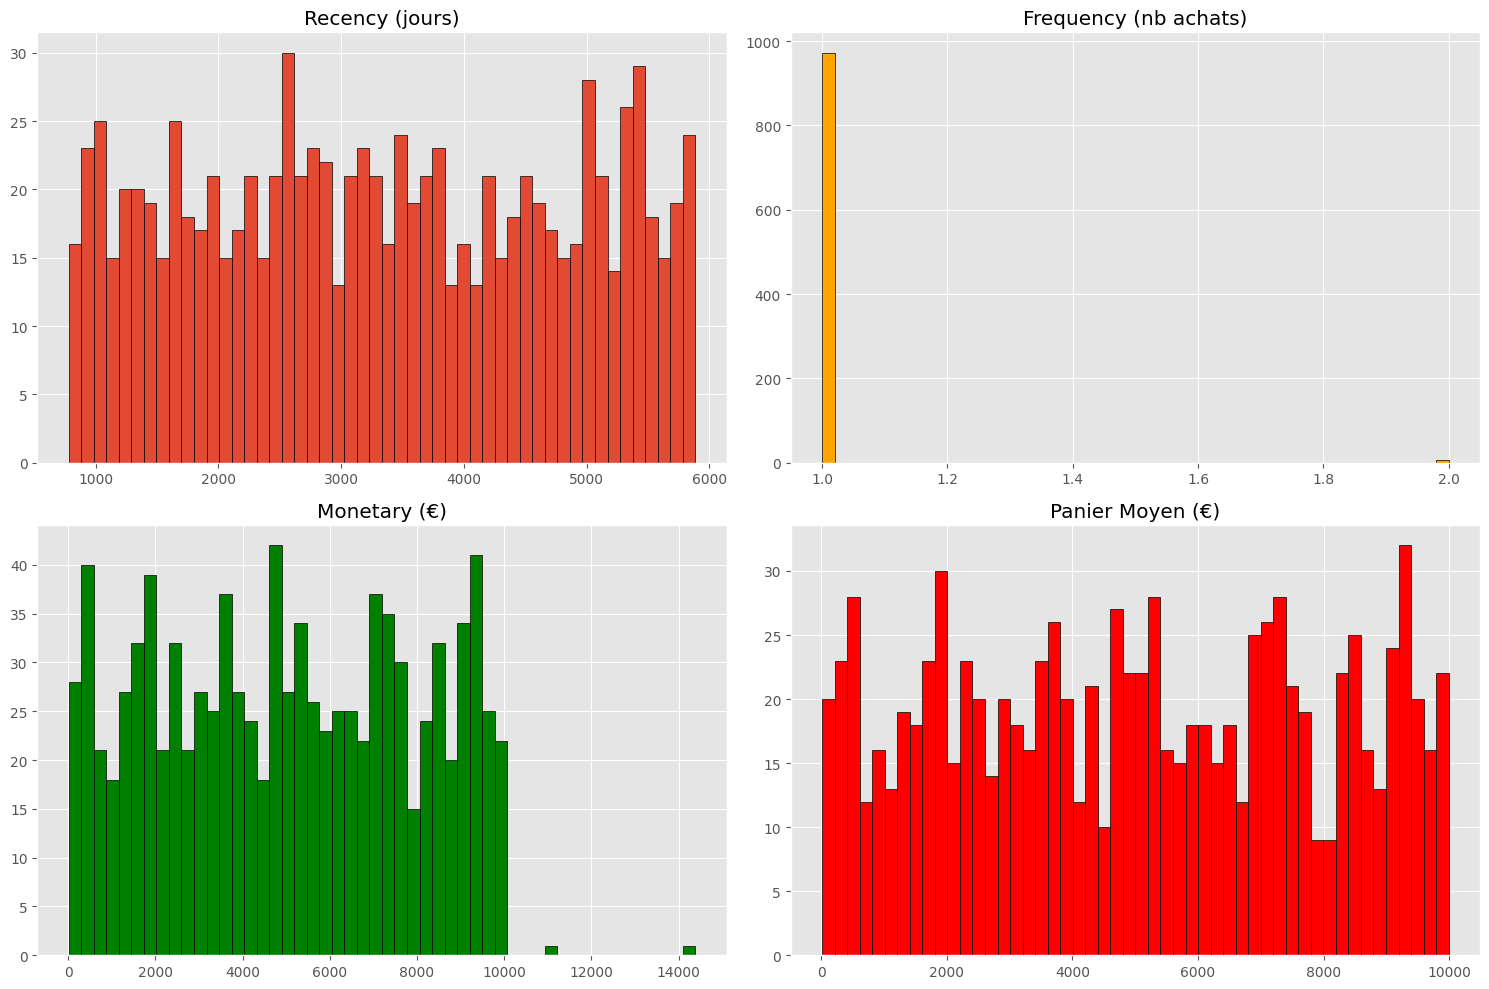

In [4]:
print("📈 Statistiques:")
print(df[['RECENCY_DAYS', 'FREQUENCY', 'MONETARY', 'AVG_TRANSACTION_VALUE']].describe())

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].hist(df['RECENCY_DAYS'], bins=50, edgecolor='black')
axes[0, 0].set_title('Recency (jours)')

axes[0, 1].hist(df['FREQUENCY'], bins=50, edgecolor='black', color='orange')
axes[0, 1].set_title('Frequency (nb achats)')

axes[1, 0].hist(df['MONETARY'], bins=50, edgecolor='black', color='green')
axes[1, 0].set_title('Monetary (€)')

axes[1, 1].hist(df['AVG_TRANSACTION_VALUE'], bins=50, edgecolor='black', color='red')
axes[1, 1].set_title('Panier Moyen (€)')

plt.tight_layout()
plt.show()

In [5]:
features = ['RECENCY_DAYS', 'FREQUENCY', 'MONETARY', 'AVG_TRANSACTION_VALUE']
X = df[features].copy()

# Cap outliers au 99e percentile
for col in features:
    percentile_99 = X[col].quantile(0.99)
    X[col] = X[col].clip(upper=percentile_99)

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✅ Features standardisées")

✅ Features standardisées


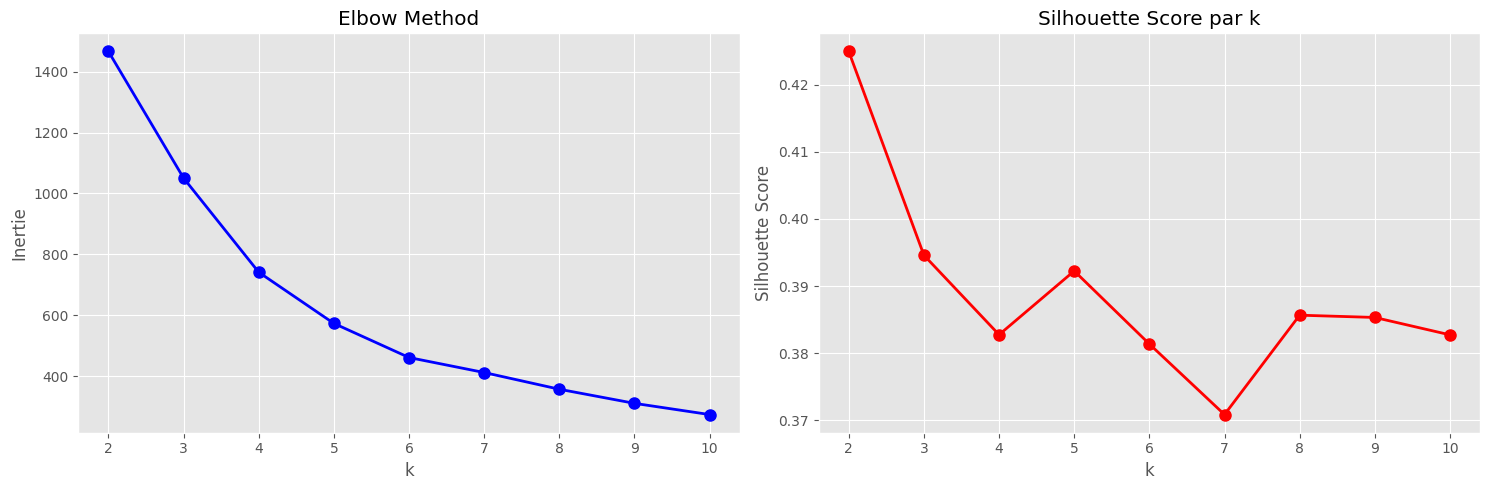


📊 Silhouette Scores:
k=2: 0.4249
k=3: 0.3946
k=4: 0.3828
k=5: 0.3922
k=6: 0.3814
k=7: 0.3709
k=8: 0.3857
k=9: 0.3853
k=10: 0.3827


In [6]:
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('k')
axes[0].set_ylabel('Inertie')
axes[0].set_title('Elbow Method')

axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('k')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score par k')

plt.tight_layout()
plt.show()

print("\n📊 Silhouette Scores:")
for k, score in zip(K_range, silhouette_scores):
    print(f"k={k}: {score:.4f}")

In [7]:
optimal_k = 5

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['cluster'] = kmeans_final.fit_predict(X_scaled)

silhouette_avg = silhouette_score(X_scaled, df['cluster'])
davies_bouldin = davies_bouldin_score(X_scaled, df['cluster'])

print(f"✅ Clustering avec k={optimal_k}")
print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Davies-Bouldin: {davies_bouldin:.4f}")
print(f"\n📈 Distribution:")
print(df['cluster'].value_counts().sort_index())

✅ Clustering avec k=5
Silhouette Score: 0.3922
Davies-Bouldin: 0.8113

📈 Distribution:
cluster
0    209
1    166
2    223
3    184
4    196
Name: count, dtype: int64


In [11]:
cluster_profiles = df.groupby('cluster').agg({
    'CUSTOMER_NAME': 'count',
    'RECENCY_DAYS': 'mean',
    'FREQUENCY': 'mean',
    'MONETARY': 'mean',
    'AVG_TRANSACTION_VALUE': 'mean',
    'CUSTOMER_LIFETIME_DAYS': 'mean'
}).round(2)

cluster_profiles.columns = ['CUSTOMER_NAME', 'RECENCY_DAYS', 'FREQUENCY',
 'MONETARY', 'AVG_TRANSACTION_VALUE',
 'CUSTOMER_LIFETIME_DAYS']


print("📊 Profil des Clusters:")
print(cluster_profiles)

📊 Profil des Clusters:
         CUSTOMER_NAME  RECENCY_DAYS  FREQUENCY  MONETARY  \
cluster                                                     
0                  209       2249.95       1.01   8521.41   
1                  166       2185.51       1.00   1520.21   
2                  223       4836.53       1.00   2493.73   
3                  184       4827.33       1.00   7408.79   
4                  196       2384.39       1.02   4979.84   

         AVG_TRANSACTION_VALUE  CUSTOMER_LIFETIME_DAYS  
cluster                                                 
0                      8438.07                   30.39  
1                      1520.21                    0.00  
2                      2493.73                    0.00  
3                      7408.79                    0.00  
4                      4939.15                   28.61  


In [17]:
def label_cluster(row):
    recency = row['RECENCY_DAYS']
    frequency = row['FREQUENCY']
    monetary = row['MONETARY']
    
    recency_threshold = df['RECENCY_DAYS'].median()
    frequency_threshold = df['FREQUENCY'].median()
    monetary_threshold = df['MONETARY'].median()
    
    if monetary > monetary_threshold * 2 and frequency > frequency_threshold and recency < recency_threshold:
        return 'Champions'
    elif monetary > monetary_threshold and frequency > frequency_threshold:
        return 'Loyal Customers'
    elif recency < recency_threshold and monetary > monetary_threshold:
        return 'Promising'
    elif recency > recency_threshold * 2 and frequency < frequency_threshold:
        return 'At Risk'
    elif recency > recency_threshold * 3:
        return 'Lost Customers'
    else:
        return 'Needs Attention'

df['segment_label'] = df.apply(label_cluster, axis=1)

print("📊 Distribution des segments:")
print(df['segment_label'].value_counts())

segment_summary = df.groupby('segment_label').agg({
    'CUSTOMER_NAME': 'count',
    'MONETARY': ['mean', 'sum'],
    'FREQUENCY': 'mean',
    'RECENCY_DAYS': 'mean'
}).round(2)

print("\n📈 Profil par Segment:")
print(segment_summary)

📊 Distribution des segments:
segment_label
Needs Attention    712
Promising          260
Loyal Customers      5
Champions            1
Name: count, dtype: int64

📈 Profil par Segment:
                CUSTOMER_NAME  MONETARY             FREQUENCY RECENCY_DAYS
                        count      mean         sum      mean         mean
segment_label                                                             
Champions                   1  11212.61    11212.61       2.0      2051.00
Loyal Customers             5   7914.87    39574.33       2.0      1938.00
Needs Attention           712   4050.99  2884303.96       1.0      3816.61
Promising                 260   7667.72  1993606.56       1.0      2069.18


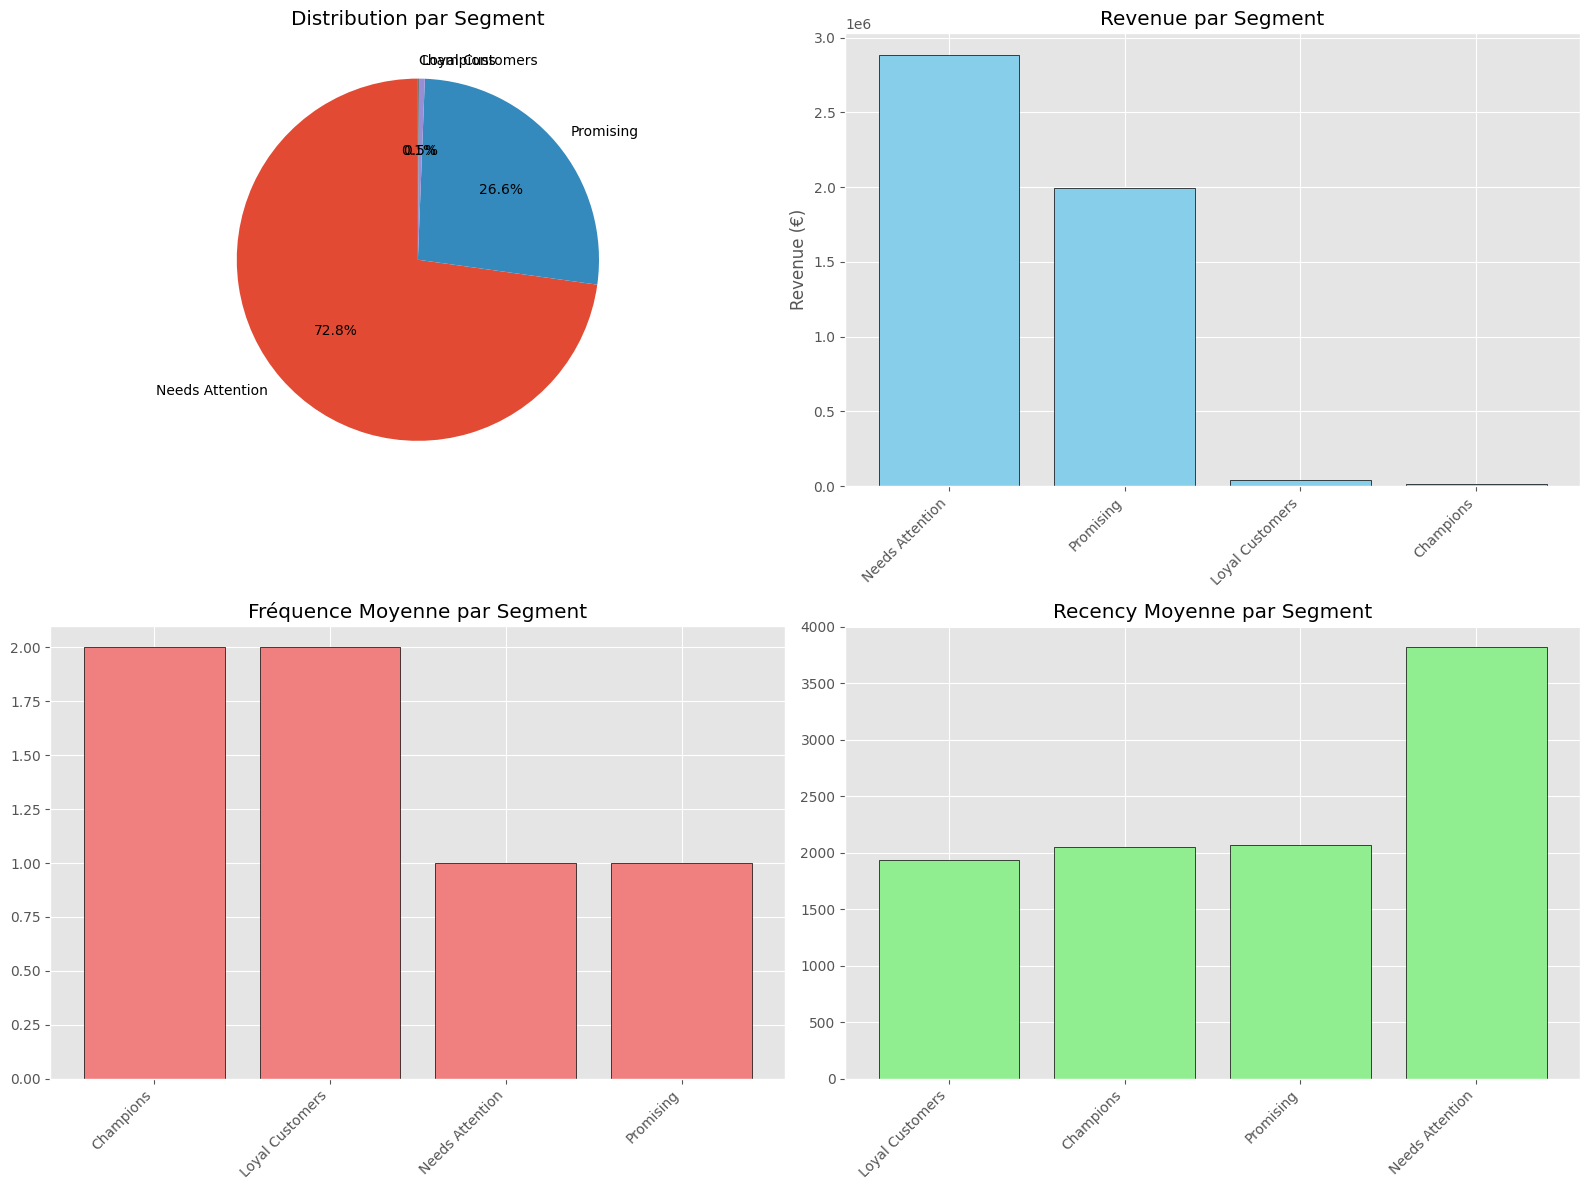

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Distribution
segment_counts = df['segment_label'].value_counts()
axes[0, 0].pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Distribution par Segment')

# Revenue
segment_revenue = df.groupby('segment_label')['MONETARY'].sum().sort_values(ascending=False)
axes[0, 1].bar(range(len(segment_revenue)), segment_revenue.values, color='skyblue', edgecolor='black')
axes[0, 1].set_xticks(range(len(segment_revenue)))
axes[0, 1].set_xticklabels(segment_revenue.index, rotation=45, ha='right')
axes[0, 1].set_title('Revenue par Segment')
axes[0, 1].set_ylabel('Revenue (€)')

# Fréquence
segment_freq = df.groupby('segment_label')['FREQUENCY'].mean().sort_values(ascending=False)
axes[1, 0].bar(range(len(segment_freq)), segment_freq.values, color='lightcoral', edgecolor='black')
axes[1, 0].set_xticks(range(len(segment_freq)))
axes[1, 0].set_xticklabels(segment_freq.index, rotation=45, ha='right')
axes[1, 0].set_title('Fréquence Moyenne par Segment')

# Recency
segment_recency = df.groupby('segment_label')['RECENCY_DAYS'].mean().sort_values()
axes[1, 1].bar(range(len(segment_recency)), segment_recency.values, color='lightgreen', edgecolor='black')
axes[1, 1].set_xticks(range(len(segment_recency)))
axes[1, 1].set_xticklabels(segment_recency.index, rotation=45, ha='right')
axes[1, 1].set_title('Recency Moyenne par Segment')

plt.tight_layout()
plt.show()

In [23]:
results_df = df[['CUSTOMER_NAME', 'REGION', 
                 'RECENCY_DAYS', 'FREQUENCY', 'MONETARY', 'AVG_TRANSACTION_VALUE']]


results_df.to_csv('customer_segments_results.csv', index=False)
cluster_profiles.to_csv('cluster_profiles.csv')

print("✅ Résultats sauvegardés!")
conn.close()

✅ Résultats sauvegardés!
